In [1]:
import torch
import tensorflow as tf

device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)
# Optional: Force GPU/CPU usage
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
    print("Using GPU")
else:
    device = '/CPU:0'
    print("Using CPU")

2025-05-04 22:05:24.646812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746396324.849436      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746396324.905052      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cuda
Using GPU


In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 16

# Set paths
image_dir = '/kaggle/input/final-data/data1/encoder_directory_new'
mask_dir = '/kaggle/input/final-data/data1/decoder_directory_new'

# Load all image and mask file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

def load_and_resize(path, size=(IMG_HEIGHT, IMG_WIDTH)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=-1)  # (224, 224, 1)

# Sanity check
sample_img = load_and_resize(image_paths[0])
print("Image shape:", sample_img.shape)


train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.30, random_state=42)

val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.50, random_state=42)


class DataGenerator(Sequence):
    def __init__(self, img_paths, mask_paths, batch_size=BATCH_SIZE, img_size=(IMG_HEIGHT, IMG_WIDTH)):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_imgs = self.img_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_masks = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]

        X = np.zeros((len(batch_imgs), *self.img_size, 1), dtype=np.float32)
        y = np.zeros((len(batch_masks), *self.img_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(batch_imgs, batch_masks)):
            X[i] = load_and_resize(img_path)
            y[i] = load_and_resize(mask_path)
            y[i] = (y[i] > 0).astype(np.float32)  # Binarize mask

        return X, y


train_gen = DataGenerator(train_imgs, train_masks)
# train_gen.to(device)
val_gen = DataGenerator(val_imgs, val_masks)
test_gen = DataGenerator(test_imgs, test_masks)

Image shape: (224, 224, 1)


In [3]:
from tensorflow.keras.models import Model, load_model
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tensorflow.keras import layers, optimizers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize



def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

input_shape = (224,224,1)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )
model_seg.summary()

I0000 00:00:1746396362.778762      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 16)   │          2,320 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 16)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 32)   │            544 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 112, 112, 32)   │            544 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 112, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 112, 112, 32)   │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 112, 112, 32)   │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 32)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 32)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)       

 Total params: 1,210,225 (4.62 MB)

 Trainable params: 1,205,841 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

In [4]:
def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)
    
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="/kaggle/working/ResUNet-model.keras", verbose=1, save_best_only=True)
with tf.device(device):
    model_seg.fit(train_gen, epochs = EPOCHS, validation_data = val_gen, callbacks = [checkpointer, earlystopping])
    

Epoch 1/16


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746396400.870104      89 service.cc:148] XLA service 0x7ee9e8003550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746396400.871064      89 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746396403.045521      89 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746396417.164516      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - loss: 0.8652 - tversky: 0.1746
Epoch 1: val_loss improved from inf to 0.76291, saving model to /kaggle/working/ResUNet-model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 105s 792ms/step - loss: 0.8641 - tversky: 0.1759 - val_loss: 0.7629 - val_tversky: 0.3031
Epoch 2/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.5280 - tversky: 0.5699
Epoch 2: val_loss improved from 0.76291 to 0.57507, saving model to /kaggle/working/ResUNet-model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.5267 - tversky: 0.5712 - val_loss: 0.5751 - val_tversky: 0.5219
Epoch 3/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2256 - tversky: 0.8627
Epoch 3: val_loss improved from 0.57507 to 0.41996, saving model to /kaggle/working/ResUNet-model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - loss: 0.2254 - tversky: 0.8629 - val_loss: 0.4200 - val_tversky: 0.6849
Epoch 4/16
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.1714 - tversky: 0.9055
Epoch 4: val_l

In [5]:
model_path = "/kaggle/working/ResUNet-model.keras"
model_seg = load_model(model_path, custom_objects={'focal_tversky': focal_tversky, 'tversky': tversky})
# Get one batch from test generator
X_test_batch, y_test_batch = test_gen[0]  # First batch

# Predict
preds = model_seg.predict(X_test_batch)

# Threshold predictions to binary masks
preds_thresholded = (preds > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


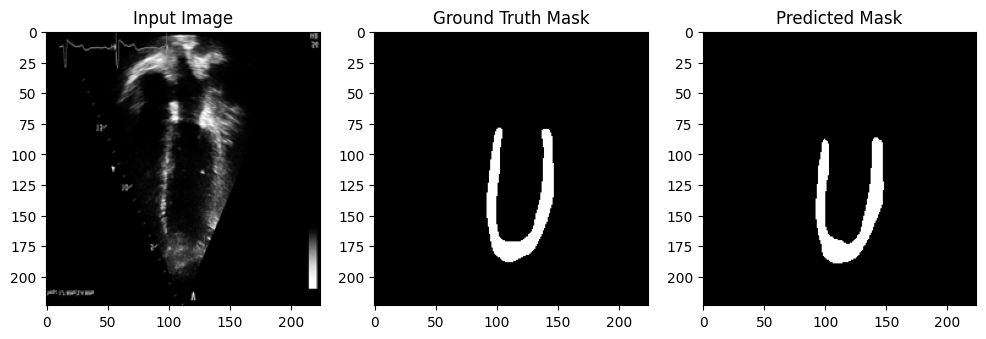

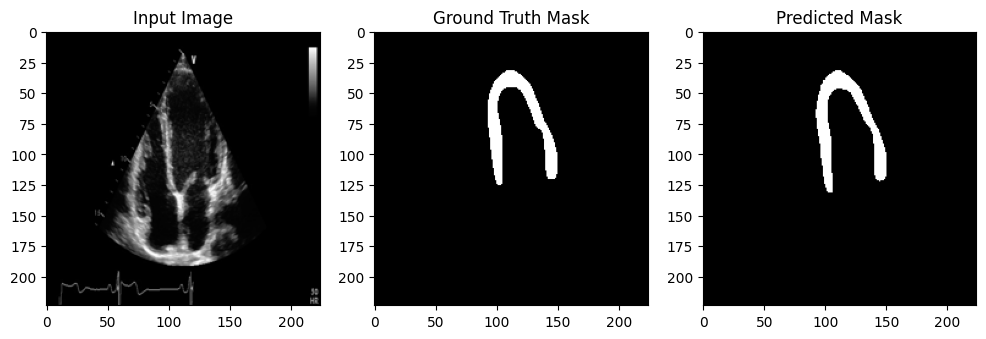

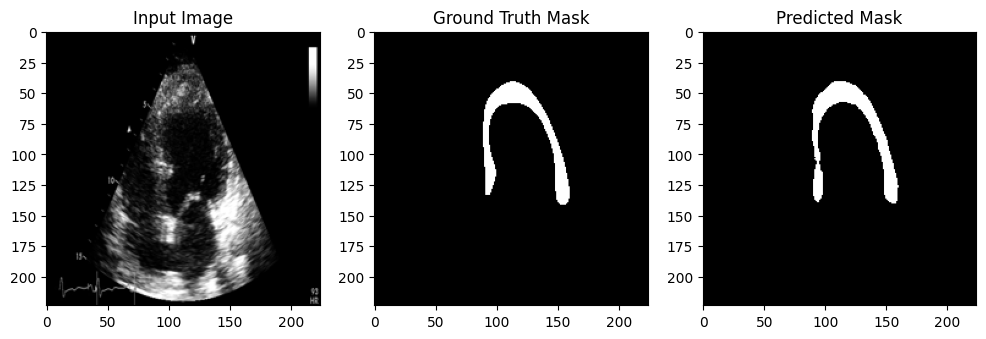

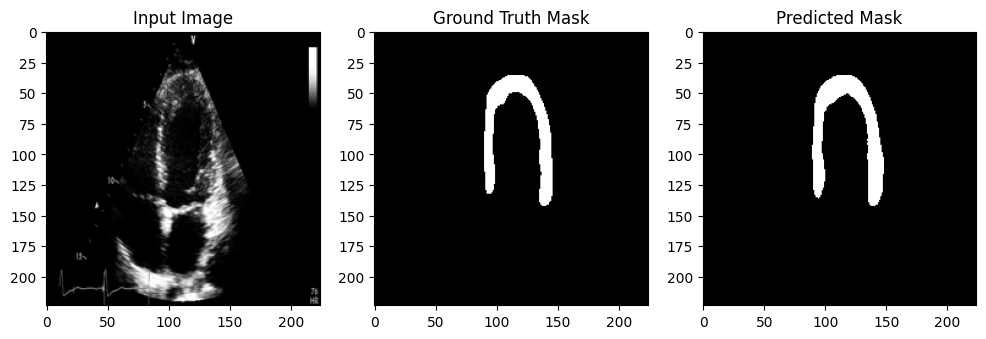

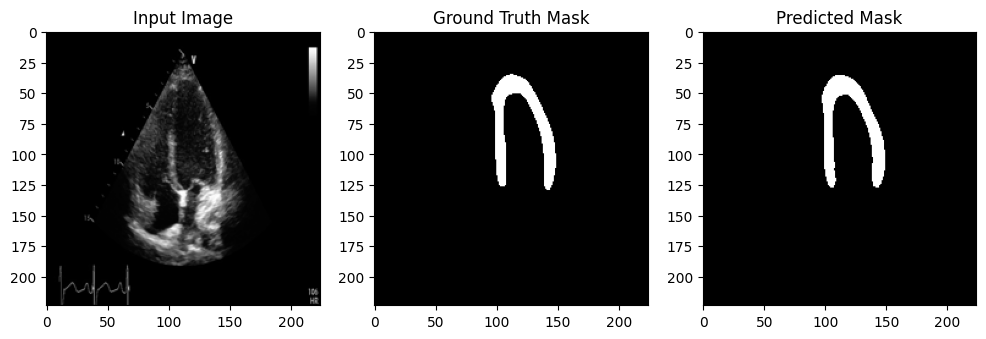

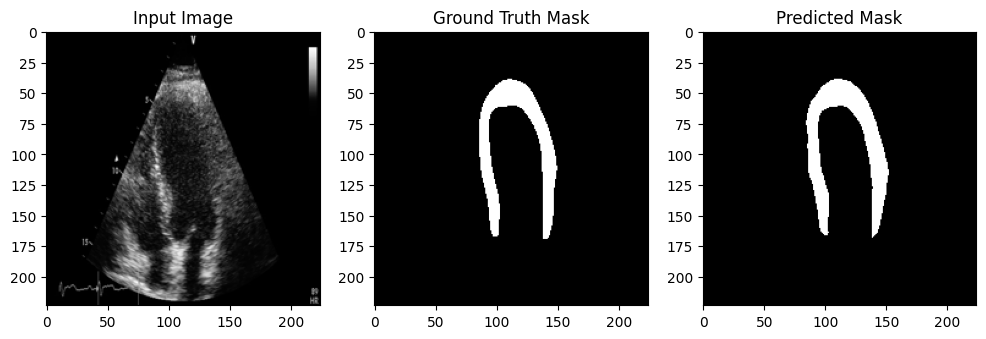

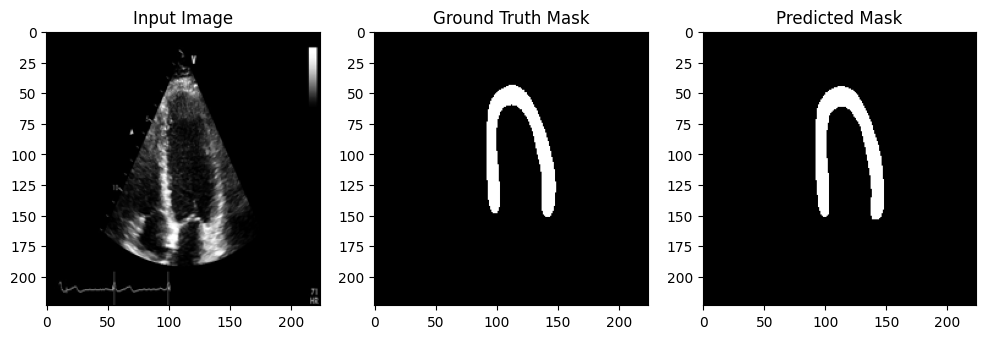

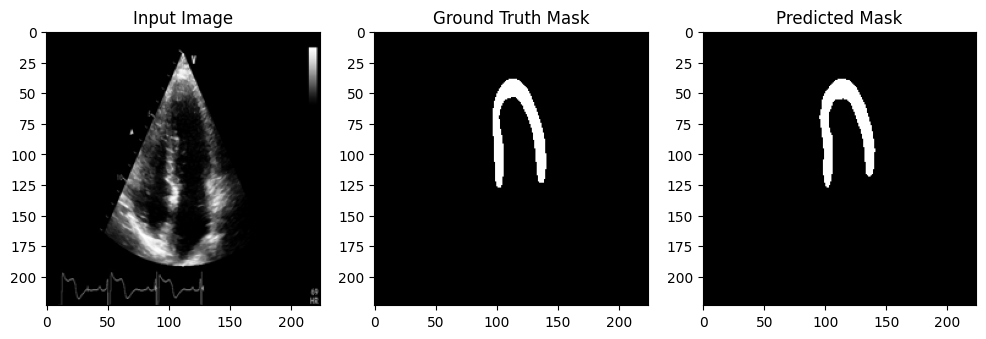

In [11]:
import matplotlib.pyplot as plt

def plot_sample(X, y_true, y_pred, index):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X[index].squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y_true[index].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[index].squeeze(), cmap='gray')

    plt.show()

# Visualize a few test samples
for i in range(8):
    plot_sample(X_test_batch, y_test_batch, preds_thresholded, i)

In [7]:
preds = model_seg.predict(test_gen)

# Threshold predictions to binary masks
preds_thresholded = (preds > 0.5).astype(np.uint8)

17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 715ms/step


In [8]:
print(preds.shape)

(529, 224, 224, 1)


In [9]:
# Assuming test_gen is your generator for test data
y_true = []
for i in range(len(test_gen)):
    _, batch_masks = test_gen[i]
    y_true.append(batch_masks)

y_true = np.concatenate(y_true, axis=0)  # Shape: (N, 224, 224, 1)
accuracy = np.mean(preds_thresholded == y_true)
print(f"Pixel-wise Accuracy: {accuracy * 100:.2f}%")

Pixel-wise Accuracy: 99.35%


In [10]:
def dice_coefficient(pred, true):
    intersection = np.sum(pred * true)
    return (2. * intersection) / (np.sum(pred) + np.sum(true) + 1e-6)

dices = [dice_coefficient(p.squeeze(), t.squeeze()) for p, t in zip(preds_thresholded, y_true)]
mean_dice = np.mean(dices)
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

Mean Dice Coefficient: 0.9254
